# Introduction

With all that you've learned, your SQL queries are getting pretty long, which can make them hard understand (and debug).

You are about to learn how to use **AS** and **WITH** to tidy up your queries and make them easier to read.

Along the way, we'll use the familiar `pets` table, but now it includes the ages of the animals. 

![](https://i.imgur.com/MXrsiAZ.png)

# AS

You learned in an earlier tutorial how to use **AS** to rename the columns generated by your queries, which is also known as **aliasing**.  This is similar to how Python uses `as` for aliasing when doing imports like `import pandas as pd` or `import seaborn as sns`.  

To use **AS** in SQL, insert it right after the column you select.  Here's an example of a query _without_ an **AS** clause:

![](https://i.imgur.com/VelX9tP.png)

And here's an example of the same query, but _with_ **AS**.

![](https://i.imgur.com/teF84tU.png)

These queries return the same information, but in the second query the column returned by the **COUNT()** function will be called `Number`, rather than the default name of `f0__`.

# WITH ... AS

On its own, **AS** is a convenient way to clean up the data returned by your query. It's even more powerful when combined with **WITH** in what's called a "common table expression".

A **common table expression** (or **CTE**) is a temporary table that you return within your query. CTEs are helpful for splitting your queries into readable chunks, and you can write queries against them. 

For instance, you might want to use the `pets` table to ask questions about older animals in particular.  So you can start by creating a CTE which only contains information about animals more than five years old like this:

![](https://i.imgur.com/0Kz8q4x.png)
            
While this incomplete query above won't return anything, it creates a CTE that we can then refer to (as `Seniors`) while writing the rest of the query.  

We can finish the query by pulling the information that we want from the CTE.  The complete query below first creates the CTE, and then returns all of the IDs from it. 

![](https://i.imgur.com/3xQZM4p.png)
    
You could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

Also, it's important to note that CTEs only exist inside the query where you create them, and you can't reference them in later queries.  So, any query that uses a CTE is always broken into two parts: (1) first, we create the CTE, and then (2) we write a query that uses the CTE.

# Example: How many Bitcoin transactions are made per month?

We're going to use a CTE to find out how many Bitcoin transactions were made each day for the entire timespan of a bitcoin transaction dataset.

We'll investigate the `transactions` table. Here is a view of the first few rows.  (_The corresponding code is hidden, but you can un-hide it by clicking on the "Code" button below._)

In [1]:

from google.cloud import bigquery

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the "crypto_bitcoin" dataset
dataset_ref = client.dataset("crypto_bitcoin", project="bigquery-public-data")

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

# Construct a reference to the "transactions" table
table_ref = dataset_ref.table("transactions")

# API request - fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "transactions" table
client.list_rows(table, max_results=5).to_dataframe()

Using Kaggle's public dataset BigQuery integration.


,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,aaac8b454e079237b8509c422b8a0ebd95e3eca5944b95...,137,137,1,0,000000000000000000d6cdda66edb65e8969566ca65fe3...,484015,2017-09-07 13:43:30+00:00,2017-09-01,0,1,None,1266641901,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
1,8505c4277a8da0450cb6fd345b409a87218e09987c7e92...,193,166,1,0,000000000000000000427219aa8b931acb167f582e9b9c...,485083,2017-09-13 19:30:26+00:00,2017-09-01,0,2,None,1367011480,True,0,[],"[{'index': 0, 'script_asm': 'OP_HASH160 6dffc0..."
2,d1a2060a08e8cd54480de8a0aac761b8667c175a7de08e...,213,186,1,0,000000000000000000d5ed15beb3085719e8f1b95f2924...,485005,2017-09-13 10:25:46+00:00,2017-09-01,0,2,None,1255484937,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
3,2fba35aaba056d4028d512c0fb134ff41d2d5c504fc7a1...,213,186,1,0,0000000000000000009fd230518a5b3d50ebcd5120a844...,486934,2017-09-25 17:28:19+00:00,2017-09-01,0,2,None,1431309437,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
4,630af30aa1ade3de86df071d35b6eb28e0590cf7e0bcaa...,217,190,1,0,000000000000000000841e1fa84e8e5abdfa000936524c...,483854,2017-09-06 16:06:09+00:00,2017-09-01,0,2,None,1530785512,True,0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


Since the `block_timestamp` column contains the date of each transaction in DATETIME format, we'll convert these into DATE format using the **DATE()** command.

We do that using a CTE, and then the next part of the query counts the number of transactions for each date and sorts the table so that earlier dates appear first. 

In [2]:
# Query to select the number of transactions per date, sorted by date
query_with_CTE = """ 
                 WITH time AS 
                 (
                     SELECT DATE(block_timestamp) AS trans_date
                     FROM `bigquery-public-data.crypto_bitcoin.transactions`
                 )
                 SELECT COUNT(1) AS transactions,
                        trans_date
                 FROM time
                 GROUP BY trans_date
                 ORDER BY trans_date
                 """

# Set up the query (cancel the query if it would use too much of 
# your quota, with the limit set to 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query_with_CTE, job_config=safe_config)

# API request - run the query, and convert the results to a pandas DataFrame
transactions_by_date = query_job.to_dataframe()

# Print the first five rows
transactions_by_date.head()

,transactions,trans_date
0,1,2009-01-03
1,14,2009-01-09
2,61,2009-01-10
3,93,2009-01-11
4,101,2009-01-12


Since they're returned sorted, we can easily plot the raw results to show us the number of Bitcoin transactions per day over the whole timespan of this dataset.

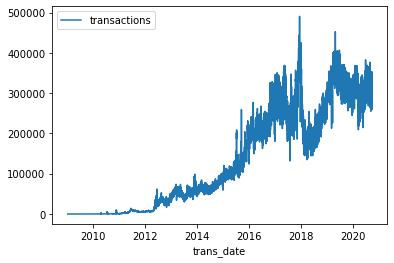

In [3]:
transactions_by_date.set_index('trans_date').plot()

As you can see, common table expressions (CTEs) let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery, because it is vastly faster than doing the work in Pandas.

# Your turn
You now have the tools to stay organized even when writing more complex queries.  Now **[use them here](https://www.kaggle.com/kernels/fork/682113)**.


---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161314) to chat with other Learners.*